''' Loading and Preprocessing Text '''
Load and preprocess the provided text data, converting it to lowercase, removing special characters, digits, and redundant whitespace, and excluding meaningless words.

In [2]:
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob

df = pd.read_csv('AE1_vishing_data_zipped.csv', 
                  engine='python')

In [3]:
english = df['lang'] == 'en' #filter language so it's only english
df = df.loc[english] #apply this to entire df

stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

def clean_text(text):
    """
    Cleans tweet text by removing URLs, mentions, hashtags, punctuation, numbers, extra whitespace, make lower case, and tokenize.
    
    Args:
        text (str): Original tweet text.
        
    Returns:
        list: Cleaned text.
    """
    #make text lowercase
    text = text.lower()
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #removes URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    #remove mentions
    text = re.sub(r'@\w+', ' ', text)
    #remove hashtags
    text = re.sub(r'#\w+', ' ', text)
    #remove punctuation
    text = re.sub('[^\w\s]','',text)
    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #tokenize 
    words = text.split()
    #remove stopwords
    words = [word for word in words if word not in stop_words]

    return words

df["clean_text"] = df["text"].astype(str).apply(clean_text) #apply function to text column to make clean_text
print(df["clean_text"].head(10)) #print first 10 rows of clean_text

0     [scam, calls, going, round, call, say, got, nu...
3     [yet, another, scam, call, allegedly, lines, i...
5     [scam, alert, beware, scammers, impersonating,...
6                [know, difference, amp, check, answer]
8     [guys, explain, cancelled, services, x, yet, s...
9     [need, help, received, call, stating, needed, ...
10                [prank, call, tech, support, scammer]
12    [calls, bought, info, needs, bits, get, accoun...
13    [rt, say, cr, scam, government, released, guid...
14    [hi, case, unaware, received, phone, call, mor...
Name: clean_text, dtype: object


''' Analysing Text ''' 
Analysed the processed tweets posted by the top ten frequent users by counting the frequency of words, determining the vocabulary richness, and identifying any common words between the users.

In [5]:
#filter by top users
top_users = df["author_id"].value_counts().head(10).index #take top 10 most common author ids
df_top_users = df[df["author_id"].isin(top_users)] #create new dataframe with only top users

#count words per user
user_word_counts = {user: Counter() for user in top_users} #creates a dictionary with 'user: Counter()' for the top 10 users

for index, row in df_top_users.iterrows(): #updates user_word_counts dictionary with clean_text (lists of words) inside Counter(), creating a dictionary within a dictionary
    user_word_counts[row["author_id"]].update(row["clean_text"])
     
#reformate as list of dictionaries to print
user_word_frequencies = []
for user, word_counter in user_word_counts.items(): #iterates over 'user: Counter()'  
    for word, count in word_counter.items(): #within each user, iterates over 'Counter()' (each word and their count)
        user_word_frequencies.append({"User": user, "Word": word, "Frequency": count}) #add to list with corresponding titles

print("User Word Frequences: ")
print(user_word_frequencies)
print()

vocab_richness_list = []
for user in top_users: #iterates over each user in top_users
    total_words = sum(user_word_counts[user].values()) #calculate total words
    unique_words = len(user_word_counts[user]) #calculate unique words the user uses
    vocab_richness = unique_words / total_words if total_words > 0 else 0  #calculate vocab richness by dividing unique_words by total_words
    vocab_richness_list.append({"User": user, "Vocab Richness": vocab_richness}) #adds them to empty list with corresponding titles
        
#identify common words across top users
user_word_sets = [set(user_word_counts[user].keys()) for user in top_users] #list of sets of unique words each user uses
common_words = set.intersection(*user_word_sets) if len(user_word_sets) > 1 else set() #find words that are in exists in all sets

print("Vocab Richness Per User: ")
print(vocab_richness_list)
print()

print("Common Word(s):")
print(common_words)

User Word Frequences: 
[{'User': 'Js52nhWF', 'Word': 'calls', 'Frequency': 956}, {'User': 'Js52nhWF', 'Word': 'bought', 'Frequency': 497}, {'User': 'Js52nhWF', 'Word': 'info', 'Frequency': 512}, {'User': 'Js52nhWF', 'Word': 'needs', 'Frequency': 513}, {'User': 'Js52nhWF', 'Word': 'bits', 'Frequency': 496}, {'User': 'Js52nhWF', 'Word': 'get', 'Frequency': 510}, {'User': 'Js52nhWF', 'Word': 'account', 'Frequency': 1870}, {'User': 'Js52nhWF', 'Word': 'watch', 'Frequency': 1619}, {'User': 'Js52nhWF', 'Word': 'requests', 'Frequency': 1675}, {'User': 'Js52nhWF', 'Word': 'financial', 'Frequency': 1577}, {'User': 'Js52nhWF', 'Word': 'numbers', 'Frequency': 1595}, {'User': 'Js52nhWF', 'Word': 'business', 'Frequency': 1311}, {'User': 'Js52nhWF', 'Word': 'already', 'Frequency': 1454}, {'User': 'Js52nhWF', 'Word': 'themhang', 'Frequency': 457}, {'User': 'Js52nhWF', 'Word': 'call', 'Frequency': 2665}, {'User': 'Js52nhWF', 'Word': 'company', 'Frequency': 1776}, {'User': 'Js52nhWF', 'Word': 'back', '

''' Visualising Data '''
Visualise the analysed data by generating word clouds for top 10 users and compute the sentiment scores of those users and plot them overtime.

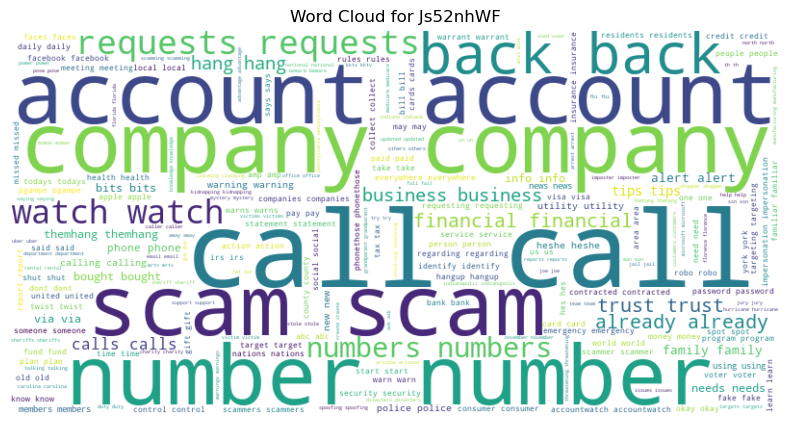

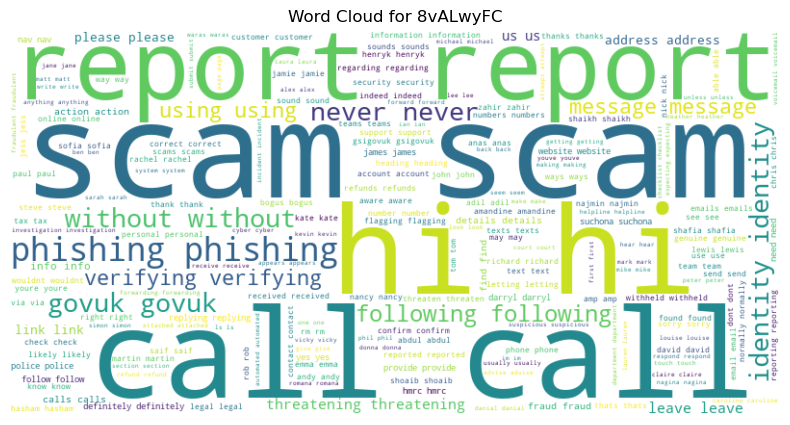

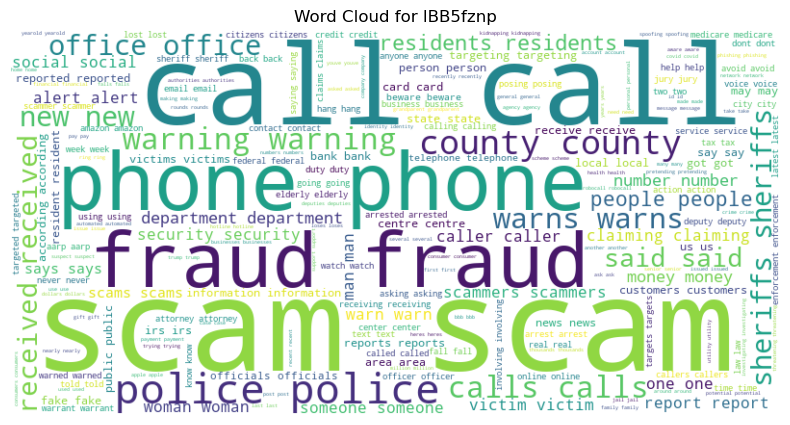

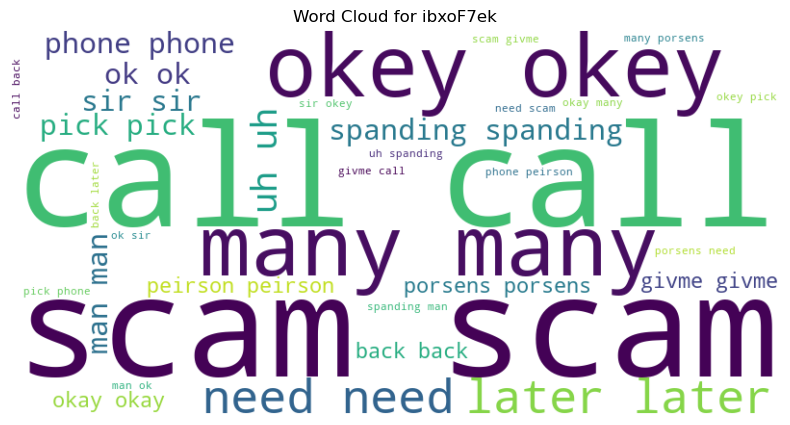

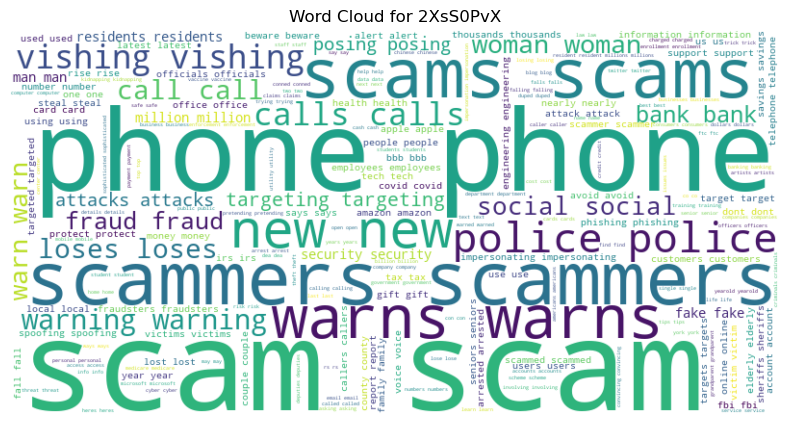

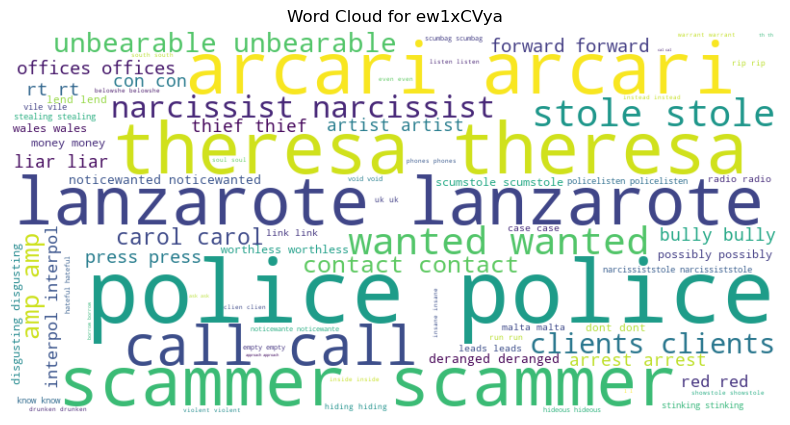

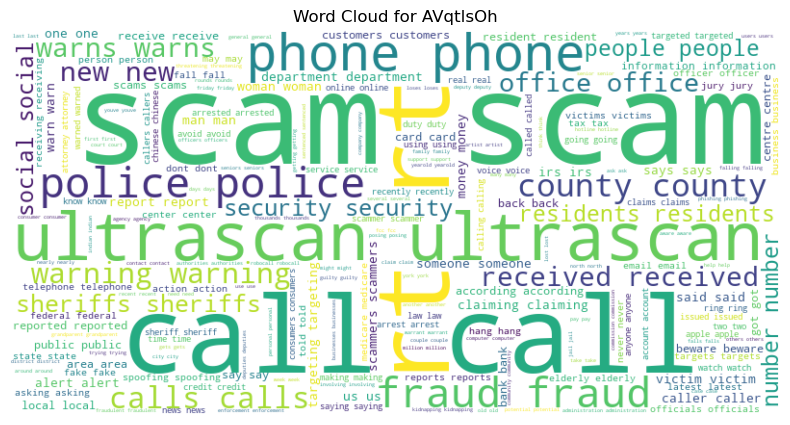

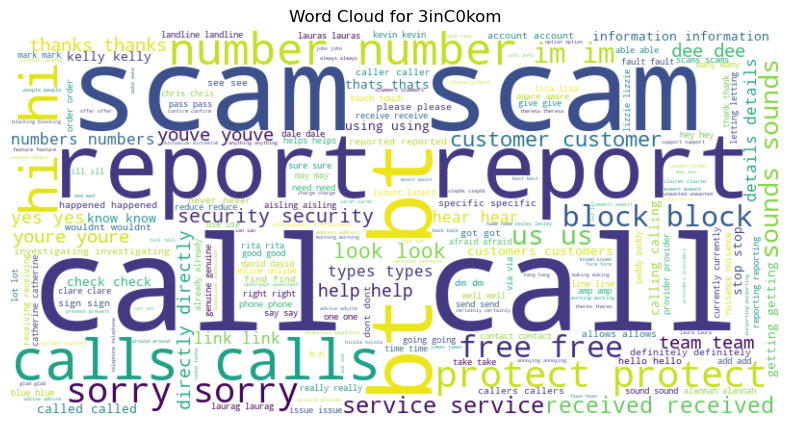

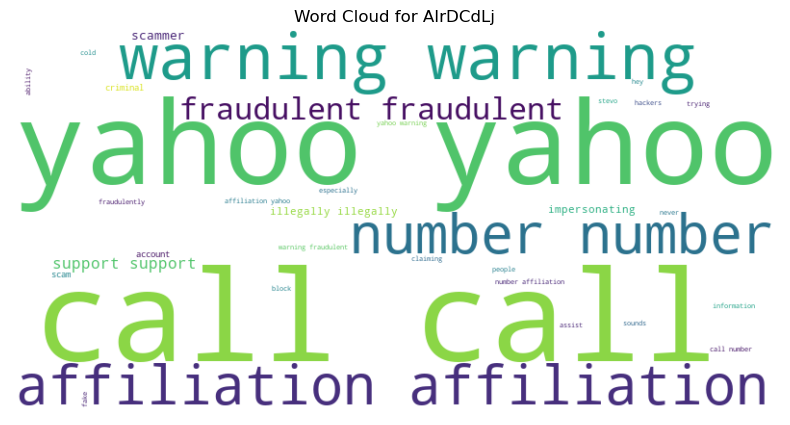

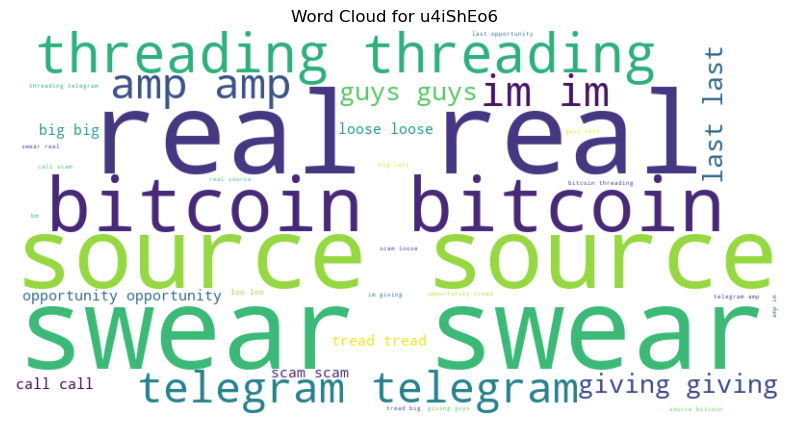

In [7]:
for user in top_users:
    words = " ".join(user_word_counts[user].elements())  #get all words used by the user, repeated based on count into a single string separated by " "
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words) #generates wordcloud where the more frequent the words are the bigger

    #plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off") #hides axes
    plt.title(f"Word Cloud for {user}")
    plt.show()

In [8]:
def compute_sentiment(text):
    """
    Computes the sentiment polarity of the given text using TextBlob.
    
    Args:
        text (str): Tweet text.
        
    Returns:
        float: Sentiment polarity score.
    """
    blob = TextBlob(text) #uses NLP library TextBlob
    return blob.sentiment.polarity #calculates sentiment polarity and returns sentiment score as a number 

In [9]:
df['created_at'] = pd.to_datetime(df['created_at']) #make create_at column in datetime format
df['date'] = df['created_at'].dt.date #returns numpy array of python datetime

In [10]:
df_top_users = df[df['author_id'].isin(top_users)].copy()  #create copy of df_top_users to use for graph

df_top_users.loc[:, 'polarity'] = df_top_users['text'].apply(compute_sentiment) #apply compute sentiment function to top users text

grouped = df_top_users.groupby(['author_id', 'date'])['polarity'].mean().reset_index() #group data by author_id and date, taking average polarity

grouped = grouped.sort_values(by=['author_id', 'date']) #sort the grouped data by author_id and date


In [ ]:
plt.figure(figsize=(12, 6)) #plot time series sentiment analysis
sns.lineplot(data=grouped, x='date', y='polarity', hue='author_id', alpha=0.7)  

plt.xlabel("Date")
plt.ylabel("Average Sentiment Polarity")
plt.title("Time Series Sentiment Analysis (Top Users Only)")
plt.legend(title="User", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
''' Visualising N-grams '''
# Create n-grams (till quad-gram), identify top 5 n-grams for each category, and create
# a normalised time-series visualisation by dividing the number of posts (tweets
# containing those n-grams) by number of users.


In [ ]:
def ngrams_generator(df_clean_text, n):
    """
    Generates n-grams from a DataFrame column of cleaned text.
    
    Parameters:
        df_clean_text (pd.Series): A Pandas Series containing cleaned text.
        n (int): The number of tokens per n-gram.
    
    Returns:
        list: A list of n-gram strings.
    """
    #combine all text entries into one large string
    combined_text = ' '.join(df_clean_text.dropna().astype(str))  #remove NaNs and join text
    #tokenize combined text into words
    tokens = combined_text.split()
    #use zip to create n-grams
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]  #return n-grams as a list

#generate ngrams using ngrams_gernerator and clean_text from df_top_users
unigrams = ngrams_generator(df_top_users["clean_text"], 1)
bigrams = ngrams_generator(df_top_users["clean_text"], 2)
trigrams = ngrams_generator(df_top_users["clean_text"], 3)
quadgrams = ngrams_generator(df_top_users["clean_text"], 4)

#count number of ngrams using Counter() function
unigrams_counts = Counter(unigrams)
bigrams_counts = Counter(bigrams)
trigrams_counts = Counter(trigrams)
quadgrams_counts = Counter(quadgrams)

#get top 5 ngrams
top_5_unigrams = [phrase for phrase, _ in unigrams_counts.most_common(5)] #extracts only the ngram from ngrams_counts and produces top 5 most frequent
top_5_bigrams = [phrase for phrase, _ in bigrams_counts.most_common(5)]
top_5_trigrams = [phrase for phrase, _ in trigrams_counts.most_common(5)]
top_5_quadgrams = [phrase for phrase, _ in quadgrams_counts.most_common(5)]

#print top 5 ngrams of each kind
print("Top 5 Unigrams:", top_5_unigrams)
print("Top 5 Bigrams:", top_5_bigrams)
print("Top 5 Trigrams:", top_5_trigrams)
print("Top 5 Quadgrams:", top_5_quadgrams)

In [ ]:
ngram_time_series = [] #create empty list to hold ngram time series 

for ngram_list, label in zip( #pairs ngrams with each label (eg. top_5_unigrams -> unigram)
    [top_5_unigrams, top_5_bigrams, top_5_trigrams, top_5_quadgrams], 
    ["Unigram", "Bigram", "Trigram", "Quadgram"]
):
    for ngram in ngram_list: #iterate over each ngram in list
        df_top_users[f'contains_{ngram}'] = df_top_users['clean_text'].apply(lambda x: 1 if ngram in str(x) + "," else 0) #check if ngram is present in clean text, if present: assigns 1, if not: 0
                                                                                             #str(x) makes sure it's treated as a string and ',' makes sure that if its within another word it is still counted 
        #group by date and compute normalization
        grouped = df_top_users.groupby('date').agg( #groups data by date
            posts_with_ngram=(f'contains_{ngram}', 'sum'), #sums all occerences that a tweet contains ngram, count number of tweets that contain ngram
            unique_users=('author_id', 'nunique') #counts number of unique users posted on a date
        ).reset_index()
        
        grouped['normalized_frequency'] = grouped['posts_with_ngram'] / grouped['unique_users'] #computes the normalized frequency of the ngram by dividing the number of tweets with the ngram by the number of unique users
        grouped['ngram'] = ngram  #stores ngram label 
        grouped['ngram_type'] = label  #stores type of ngram
        
        ngram_time_series.append(grouped) #added to list

df_time_series = pd.concat(ngram_time_series, ignore_index=True) #combines all the time-series data from different ngram categories (Unigram, Bigram, etc.) and resets the index

#plot the normalized time-series visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time_series, x='date', y='normalized_frequency', hue='ngram', style='ngram_type', marker="o")
#customizing the plot
plt.xlabel("Date")
plt.ylabel("Normalized Frequency (Posts with N-gram / Unique Users)")
plt.title("N-gram Normalized Time-Series Analysis")
plt.legend(title="Top N-grams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Write a reflection on your experience working on this project. 
Discuss the challenges you encountered during the development of this project, 
the solutions you implemented and the lessons you learned from the project. 
Reflect on the effectiveness of the techniques used and propose potential improvements for future iterations. 

Throughout the development of this project, I encountered several challenges that required careful debugging and problem-solving. One major hurdle was computing the time series visualization for n-grams. Initially, all my y-axis values were zero, which was perplexing. After thorough investigation, I realized that the issue stemmed from the fact that clean_text was stored as lists instead of strings. By converting the lists into strings, I was able to process and analyze the text correctly, leading to meaningful visualization results.
Another challenge was working with nested dictionaries for the text analysis portion. Structuring and retrieving data efficiently was tricky, and I found myself heavily relying on my previous notes and knowledge of dictionaries. The key to overcoming this was breaking down the problem into smaller, manageable components, ensuring that each piece functioned correctly before integrating everything together.
Additionally, debugging was particularly frustrating when the code would take a long time to run without providing clear error messages. To address this, I began isolating sections of code that took longer to execute and running them separately for debugging. This approach helped me pinpoint issues faster and optimize performance.
Overall, the most effective debugging strategy I used was printing intermediate results at various stages to trace the root cause of errors. This systematic approach significantly improved my ability to identify and resolve issues quickly.

Through this project, I gained valuable insights into structured problem-solving and debugging techniques. One of the biggest takeaways was the importance of breaking down complex tasks into smaller, manageable steps. By simplifying the problem, I was able to address each component individually and then integrate them seamlessly.
Additionally, I learned that effective debugging often requires strategic isolation of different parts of the code. Instead of running the entire script repeatedly, running smaller sections separately not only saved time but also made it easier to identify the exact source of an issue.
Another key lesson was the value of leveraging past knowledge and documentation. When working with nested data structures like dictionaries, revisiting my notes and previous projects provided guidance and helped reinforce my understanding of best practices.

The techniques used in this project were generally effective in achieving the desired outcomes, particularly in preprocessing, n-gram analysis, and visualization. The text preprocessing approach efficiently handled lowercasing, removing special characters, digits, and stop words, ensuring that the data was clean for further analysis. However, improvements could be made to refine the text processing further to make it more consistent and easier to analyze.
Using simple counting methods for frequency analysis worked well, but in future projects, I could explore ways to optimize performance when working with larger datasets. Additionally, instead of iterating through rows manually, finding ways to make these operations more efficient would help speed up the process.
For visualization, the tools I used were effective in displaying n-gram trends, but in the future, I could look into making these visualizations more interactive and easier to interpret. This could provide better insights and make it easier to identify important patterns over time.
Lastly, making the project more memory efficient would help when handling large datasets. Exploring different ways to store and process data more efficiently could be beneficial for future iterations. By implementing these improvements, future projects could be more efficient, easier to manage, and provide even better results.

Works Cited

“Removing Stop Words with NLTK in Python.” GeeksforGeeks, January 3, 2024. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/. 